In [1]:
import torch;
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import pandas as pd
import torchvision.models as models 
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.optim import lr_scheduler
import seaborn as sns
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import copy
from tqdm import tqdm
#from model import VAE

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from dataloader import *
from cnnlstmnetwork import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
#only on validation set
csv_path = 'progress.csv'
img_path = '/home/vip/sayan-mandal/datasets/obj_criteria/good_reduced/'

CDL = CNNLSTMDataLoader(csv_path, img_path, transform = transforms.Compose([transforms.Resize(64),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),timestep=3)

#random sampler
batch_size = 64
validation_split = .2
test_split = .2
train_split = 1-validation_split-test_split
shuffle_dataset = True

# Creating data indices for training and validation splits:
dataset_size = len(CDL)
indices = list(range(dataset_size))
split_train = int(np.floor(train_split * dataset_size))
split_valid = int(np.floor((train_split+validation_split) * dataset_size))
if shuffle_dataset :
    np.random.shuffle(indices)
train_indices, val_indices, test_indices =  indices[:split_train],indices[split_train:split_valid],indices[split_valid:]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=test_sampler)

In [4]:
torch.cuda.empty_cache()
tl = iter(train_loader)
dat,_,_ = next(tl)
bs, ts, C, H, W = dat.shape
n_out = 1

model = CNNLSTMNet(channels = C, ts = ts, n_out = n_out, device = device).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)  #,momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150], gamma= 0.1)
criterion = nn.MSELoss()  # this is for regression mean squared loss

In [5]:
epochs = 200
best_loss =float('inf')
ep, trainloss, validloss, testloss = [],[],[],[]
testep, totloss = [],[]
besttrloss, bestvalloss, besttsloss = 0,0,0
for epoch in range(1,epochs+1):
    model.train()
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    trloss = 0
    for batch_idx, (data, targets, _) in loop:
        optimizer.zero_grad() 
        data = Variable(data).to(device)
        targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

        #forward pass
        scores = model(data)
        loss = criterion(scores, targets)
        trloss += loss.item()
        #backward pass   
        loss.backward()

        #gradient descent
        optimizer.step()
        loop.set_description(f"Epoch [{epoch}/{epochs}]")
        loop.set_postfix(batch_loss = loss.item(), running_loss = trloss )
    scheduler.step()

    model.eval()
    valloss = 0
    with torch.no_grad():
        for data, targets, _ in valid_loader:
            data = Variable(data).to(device)
            targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

            
            scores = model(data)
            loss = criterion(scores, targets)

            valloss += loss.item()

    if valloss < best_loss:
        tsloss = 0
        with torch.no_grad():
            for data, targets, _ in test_loader:
                data = Variable(data).to(device)
                targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

                
                scores = model(data)
                loss = criterion(scores, targets)

                tsloss += loss.item()
            testloss += [tsloss]
            testep += [epoch]
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f} ===========> {:.4f} | Test Loss: {:.4f} | Saving model...".format(trloss, best_loss, valloss, tsloss)
        best_loss = valloss
        bestvalloss = valloss
        besttrloss = trloss
        besttsloss = tsloss
        best_e = epoch
        best_model = copy.deepcopy(model)
    else:
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f}".format(trloss, valloss)

    print(to_print)
    ep+=[epoch]
    trainloss += [trloss]
    validloss += [valloss]
    totloss += [trloss + valloss]

Epoch [1/200]: 100%|██████████| 101/101 [00:20<00:00,  4.94it/s, batch_loss=0.439, running_loss=56.4]


Train Loss: 56.3920 | Valid Loss: inf ===========> 18.5861 | Test Loss: 15.8077 | Saving model...


Epoch [2/200]: 100%|██████████| 101/101 [00:20<00:00,  4.97it/s, batch_loss=0.408, running_loss=55.8]


Train Loss: 55.7803 | Valid Loss: 18.5861 ===========> 18.3649 | Test Loss: 15.8263 | Saving model...


Epoch [3/200]: 100%|██████████| 101/101 [00:20<00:00,  4.97it/s, batch_loss=0.381, running_loss=55.5]


Train Loss: 55.4872 | Valid Loss: 18.5294


Epoch [4/200]: 100%|██████████| 101/101 [00:20<00:00,  4.98it/s, batch_loss=1.16, running_loss=55.7]


Train Loss: 55.6778 | Valid Loss: 18.5589


Epoch [5/200]: 100%|██████████| 101/101 [00:20<00:00,  5.00it/s, batch_loss=0.228, running_loss=54.5]


Train Loss: 54.5191 | Valid Loss: 18.3649 ===========> 18.3187 | Test Loss: 15.5441 | Saving model...


Epoch [6/200]: 100%|██████████| 101/101 [00:20<00:00,  4.93it/s, batch_loss=0.807, running_loss=54.2]


Train Loss: 54.1842 | Valid Loss: 18.3187 ===========> 17.9825 | Test Loss: 16.1804 | Saving model...


Epoch [7/200]: 100%|██████████| 101/101 [00:20<00:00,  4.95it/s, batch_loss=0.233, running_loss=52.7]


Train Loss: 52.6517 | Valid Loss: 18.1002


Epoch [8/200]: 100%|██████████| 101/101 [00:20<00:00,  4.99it/s, batch_loss=0.207, running_loss=52.2]


Train Loss: 52.1961 | Valid Loss: 17.9825 ===========> 17.5680 | Test Loss: 14.9878 | Saving model...


Epoch [9/200]: 100%|██████████| 101/101 [00:20<00:00,  5.03it/s, batch_loss=0.578, running_loss=51.3]


Train Loss: 51.2901 | Valid Loss: 42.5381


Epoch [10/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.34, running_loss=52.8]


Train Loss: 52.8229 | Valid Loss: 17.5680 ===========> 17.3651 | Test Loss: 14.7269 | Saving model...


Epoch [11/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.205, running_loss=49.2]


Train Loss: 49.1977 | Valid Loss: 17.9473


Epoch [12/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.997, running_loss=54.1]


Train Loss: 54.1295 | Valid Loss: 18.7675


Epoch [13/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=1.13, running_loss=54.4]


Train Loss: 54.4157 | Valid Loss: 20.1863


Epoch [14/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=1.38, running_loss=50.3]


Train Loss: 50.2546 | Valid Loss: 22.6471


Epoch [15/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.214, running_loss=44.9]


Train Loss: 44.9310 | Valid Loss: 18.0364


Epoch [16/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.516, running_loss=42.8]


Train Loss: 42.7559 | Valid Loss: 17.3651 ===========> 17.3603 | Test Loss: 15.0172 | Saving model...


Epoch [17/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.277, running_loss=45.1]


Train Loss: 45.0522 | Valid Loss: 18.5574


Epoch [18/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.442, running_loss=55.4]


Train Loss: 55.4123 | Valid Loss: 18.1725


Epoch [19/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=1.49, running_loss=54.6]


Train Loss: 54.5527 | Valid Loss: 19.6609


Epoch [20/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.184, running_loss=51.2]


Train Loss: 51.2409 | Valid Loss: 18.3902


Epoch [21/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.274, running_loss=48.8]


Train Loss: 48.8482 | Valid Loss: 17.6240


Epoch [22/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.156, running_loss=45.3]


Train Loss: 45.3360 | Valid Loss: 17.3603 ===========> 16.0057 | Test Loss: 13.8787 | Saving model...


Epoch [23/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.409, running_loss=44.9]


Train Loss: 44.8656 | Valid Loss: 24.1685


Epoch [24/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.245, running_loss=42]


Train Loss: 41.9648 | Valid Loss: 18.5886


Epoch [25/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.297, running_loss=40.4]


Train Loss: 40.3697 | Valid Loss: 16.6079


Epoch [26/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.352, running_loss=34.1]


Train Loss: 34.0536 | Valid Loss: 27.1737


Epoch [27/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.267, running_loss=32.2]


Train Loss: 32.1666 | Valid Loss: 16.4147


Epoch [28/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.332, running_loss=29.5]


Train Loss: 29.4766 | Valid Loss: 17.7548


Epoch [29/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.181, running_loss=25.9]


Train Loss: 25.9475 | Valid Loss: 16.0057 ===========> 15.3427 | Test Loss: 13.1920 | Saving model...


Epoch [30/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.141, running_loss=24.8]


Train Loss: 24.7555 | Valid Loss: 15.3427 ===========> 14.6914 | Test Loss: 13.1622 | Saving model...


Epoch [31/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.233, running_loss=22.5]


Train Loss: 22.5499 | Valid Loss: 17.4051


Epoch [32/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.236, running_loss=23.2]


Train Loss: 23.1635 | Valid Loss: 18.4553


Epoch [33/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.218, running_loss=19.4]


Train Loss: 19.4289 | Valid Loss: 14.6914 ===========> 13.3594 | Test Loss: 11.6269 | Saving model...


Epoch [34/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.637, running_loss=18.4]


Train Loss: 18.3871 | Valid Loss: 15.7502


Epoch [35/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0919, running_loss=17.4]


Train Loss: 17.3950 | Valid Loss: 13.3594 ===========> 12.9115 | Test Loss: 11.5383 | Saving model...


Epoch [36/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.203, running_loss=14.5]


Train Loss: 14.4509 | Valid Loss: 12.9115 ===========> 12.1437 | Test Loss: 10.9039 | Saving model...


Epoch [37/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.0953, running_loss=11.5]


Train Loss: 11.5260 | Valid Loss: 13.0929


Epoch [38/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.104, running_loss=10.4]


Train Loss: 10.3997 | Valid Loss: 12.4599


Epoch [39/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.101, running_loss=8.82]


Train Loss: 8.8218 | Valid Loss: 12.1437 ===========> 11.8819 | Test Loss: 10.7059 | Saving model...


Epoch [40/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.08, running_loss=8.35]


Train Loss: 8.3483 | Valid Loss: 13.5102


Epoch [41/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.0265, running_loss=8.74]


Train Loss: 8.7355 | Valid Loss: 11.8819 ===========> 11.1407 | Test Loss: 10.3598 | Saving model...


Epoch [42/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0942, running_loss=7.07]


Train Loss: 7.0744 | Valid Loss: 13.3446


Epoch [43/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0753, running_loss=6.07]


Train Loss: 6.0711 | Valid Loss: 11.1788


Epoch [44/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.053, running_loss=6.68]


Train Loss: 6.6757 | Valid Loss: 11.7484


Epoch [45/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.051, running_loss=4.78]


Train Loss: 4.7825 | Valid Loss: 11.1407 ===========> 10.9436 | Test Loss: 10.0465 | Saving model...


Epoch [46/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.109, running_loss=5.06]


Train Loss: 5.0618 | Valid Loss: 12.6295


Epoch [47/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.0172, running_loss=4.41]


Train Loss: 4.4146 | Valid Loss: 11.2574


Epoch [48/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0691, running_loss=4.31]


Train Loss: 4.3091 | Valid Loss: 11.3110


Epoch [49/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.0477, running_loss=4.43]


Train Loss: 4.4326 | Valid Loss: 11.6246


Epoch [50/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0288, running_loss=3.51]


Train Loss: 3.5118 | Valid Loss: 10.9436 ===========> 10.4869 | Test Loss: 9.5099 | Saving model...


Epoch [51/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.0168, running_loss=3.64]


Train Loss: 3.6412 | Valid Loss: 10.6479


Epoch [52/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0254, running_loss=3.37]


Train Loss: 3.3653 | Valid Loss: 11.3510


Epoch [53/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0223, running_loss=2.84]


Train Loss: 2.8409 | Valid Loss: 11.5549


Epoch [54/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.0587, running_loss=2.98]


Train Loss: 2.9757 | Valid Loss: 11.1027


Epoch [55/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0286, running_loss=2.83]


Train Loss: 2.8268 | Valid Loss: 10.5698


Epoch [56/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0128, running_loss=2.71]


Train Loss: 2.7067 | Valid Loss: 10.5847


Epoch [57/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0248, running_loss=2.6]


Train Loss: 2.6038 | Valid Loss: 10.9704


Epoch [58/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0385, running_loss=2.44]


Train Loss: 2.4352 | Valid Loss: 10.5668


Epoch [59/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.0272, running_loss=2.41]


Train Loss: 2.4147 | Valid Loss: 10.6248


Epoch [60/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0434, running_loss=2.22]


Train Loss: 2.2247 | Valid Loss: 10.4869 ===========> 10.2221 | Test Loss: 9.4690 | Saving model...


Epoch [61/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.0202, running_loss=2.39]


Train Loss: 2.3948 | Valid Loss: 10.5504


Epoch [62/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.0461, running_loss=2.18]


Train Loss: 2.1830 | Valid Loss: 11.6348


Epoch [63/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0193, running_loss=2.3]


Train Loss: 2.3000 | Valid Loss: 10.2221 ===========> 10.1662 | Test Loss: 9.3283 | Saving model...


Epoch [64/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0151, running_loss=2.02]


Train Loss: 2.0203 | Valid Loss: 10.3921


Epoch [65/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.0168, running_loss=2.12]


Train Loss: 2.1177 | Valid Loss: 10.2360


Epoch [66/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0161, running_loss=2.06]


Train Loss: 2.0564 | Valid Loss: 10.7732


Epoch [67/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.0266, running_loss=1.87]


Train Loss: 1.8671 | Valid Loss: 10.5628


Epoch [68/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0249, running_loss=2.02]


Train Loss: 2.0155 | Valid Loss: 10.6645


Epoch [69/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0452, running_loss=1.84]


Train Loss: 1.8401 | Valid Loss: 10.6989


Epoch [70/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0128, running_loss=1.86]


Train Loss: 1.8609 | Valid Loss: 10.1715


Epoch [71/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0176, running_loss=1.72]


Train Loss: 1.7215 | Valid Loss: 10.5351


Epoch [72/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.00992, running_loss=1.72]


Train Loss: 1.7231 | Valid Loss: 10.1662 ===========> 10.0178 | Test Loss: 9.0204 | Saving model...


Epoch [73/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.0256, running_loss=1.67]


Train Loss: 1.6726 | Valid Loss: 10.1124


Epoch [74/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0189, running_loss=1.67]


Train Loss: 1.6741 | Valid Loss: 10.0178 ===========> 9.9770 | Test Loss: 9.2685 | Saving model...


Epoch [75/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0266, running_loss=1.63]


Train Loss: 1.6331 | Valid Loss: 10.5453


Epoch [76/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0161, running_loss=1.54]


Train Loss: 1.5415 | Valid Loss: 10.0130


Epoch [77/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.0177, running_loss=1.55]


Train Loss: 1.5459 | Valid Loss: 10.1672


Epoch [78/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.0187, running_loss=1.61]


Train Loss: 1.6093 | Valid Loss: 10.0360


Epoch [79/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00867, running_loss=1.46]


Train Loss: 1.4552 | Valid Loss: 10.2043


Epoch [80/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00694, running_loss=1.44]


Train Loss: 1.4395 | Valid Loss: 10.0959


Epoch [81/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.0166, running_loss=1.46]


Train Loss: 1.4627 | Valid Loss: 10.2274


Epoch [82/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.0132, running_loss=1.4]


Train Loss: 1.4016 | Valid Loss: 9.9998


Epoch [83/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.0086, running_loss=1.44]


Train Loss: 1.4437 | Valid Loss: 10.1737


Epoch [84/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.0226, running_loss=1.31]


Train Loss: 1.3092 | Valid Loss: 10.1478


Epoch [85/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0135, running_loss=1.34]


Train Loss: 1.3402 | Valid Loss: 9.9770 ===========> 9.6134 | Test Loss: 8.5928 | Saving model...


Epoch [86/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.00613, running_loss=1.42]


Train Loss: 1.4176 | Valid Loss: 10.0405


Epoch [87/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0199, running_loss=1.38]


Train Loss: 1.3810 | Valid Loss: 10.0974


Epoch [88/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0149, running_loss=1.36]


Train Loss: 1.3580 | Valid Loss: 10.0859


Epoch [89/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.016, running_loss=1.37]


Train Loss: 1.3677 | Valid Loss: 9.9717


Epoch [90/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00693, running_loss=1.29]


Train Loss: 1.2872 | Valid Loss: 9.9745


Epoch [91/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.0126, running_loss=1.24]


Train Loss: 1.2370 | Valid Loss: 10.1515


Epoch [92/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0131, running_loss=1.33]


Train Loss: 1.3262 | Valid Loss: 9.8705


Epoch [93/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.0115, running_loss=1.2]


Train Loss: 1.1967 | Valid Loss: 10.2970


Epoch [94/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00358, running_loss=1.18]


Train Loss: 1.1816 | Valid Loss: 9.8576


Epoch [95/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0119, running_loss=1.2]


Train Loss: 1.2015 | Valid Loss: 9.9357


Epoch [96/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00703, running_loss=1.21]


Train Loss: 1.2114 | Valid Loss: 10.1904


Epoch [97/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0108, running_loss=1.13]


Train Loss: 1.1271 | Valid Loss: 10.2432


Epoch [98/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.0115, running_loss=1.16]


Train Loss: 1.1557 | Valid Loss: 9.6134 ===========> 9.5368 | Test Loss: 8.6054 | Saving model...


Epoch [99/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0136, running_loss=1.17]


Train Loss: 1.1669 | Valid Loss: 10.0220


Epoch [100/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.0102, running_loss=1.2]


Train Loss: 1.1995 | Valid Loss: 9.8997


Epoch [101/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0215, running_loss=1.12]


Train Loss: 1.1218 | Valid Loss: 9.5368 ===========> 9.4095 | Test Loss: 8.4299 | Saving model...


Epoch [102/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.0128, running_loss=1.17]


Train Loss: 1.1734 | Valid Loss: 9.7856


Epoch [103/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0185, running_loss=1.14]


Train Loss: 1.1442 | Valid Loss: 9.7953


Epoch [104/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00837, running_loss=1.11]


Train Loss: 1.1109 | Valid Loss: 9.9923


Epoch [105/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.0341, running_loss=1.15]


Train Loss: 1.1527 | Valid Loss: 9.9157


Epoch [106/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.0122, running_loss=1.16]


Train Loss: 1.1595 | Valid Loss: 9.5584


Epoch [107/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.0107, running_loss=1.06]


Train Loss: 1.0580 | Valid Loss: 9.6360


Epoch [108/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.012, running_loss=1.07]


Train Loss: 1.0703 | Valid Loss: 9.5283


Epoch [109/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0118, running_loss=1.04]


Train Loss: 1.0426 | Valid Loss: 9.6238


Epoch [110/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0077, running_loss=1.02]


Train Loss: 1.0213 | Valid Loss: 9.5120


Epoch [111/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0072, running_loss=1.05]


Train Loss: 1.0531 | Valid Loss: 9.5180


Epoch [112/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00888, running_loss=1.01]


Train Loss: 1.0053 | Valid Loss: 9.5670


Epoch [113/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.00878, running_loss=1.02]


Train Loss: 1.0233 | Valid Loss: 9.7610


Epoch [114/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0139, running_loss=1.03]


Train Loss: 1.0345 | Valid Loss: 9.7274


Epoch [115/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0111, running_loss=1]


Train Loss: 1.0021 | Valid Loss: 9.9214


Epoch [116/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00473, running_loss=0.988]


Train Loss: 0.9878 | Valid Loss: 9.4859


Epoch [117/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00951, running_loss=0.98]


Train Loss: 0.9803 | Valid Loss: 9.7158


Epoch [118/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.00772, running_loss=0.952]


Train Loss: 0.9520 | Valid Loss: 9.7484


Epoch [119/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00424, running_loss=0.96]


Train Loss: 0.9602 | Valid Loss: 9.6591


Epoch [120/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0418, running_loss=0.964]


Train Loss: 0.9640 | Valid Loss: 9.4095 ===========> 9.0596 | Test Loss: 8.0917 | Saving model...


Epoch [121/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0115, running_loss=0.946]


Train Loss: 0.9458 | Valid Loss: 9.8298


Epoch [122/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.0118, running_loss=0.967]


Train Loss: 0.9667 | Valid Loss: 9.6021


Epoch [123/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00632, running_loss=0.93]


Train Loss: 0.9300 | Valid Loss: 9.8674


Epoch [124/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00797, running_loss=0.903]


Train Loss: 0.9027 | Valid Loss: 9.9050


Epoch [125/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0144, running_loss=0.915]


Train Loss: 0.9149 | Valid Loss: 9.4890


Epoch [126/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.016, running_loss=0.88]


Train Loss: 0.8802 | Valid Loss: 9.1843


Epoch [127/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00802, running_loss=0.875]


Train Loss: 0.8748 | Valid Loss: 9.6166


Epoch [128/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00629, running_loss=0.859]


Train Loss: 0.8591 | Valid Loss: 9.5808


Epoch [129/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00625, running_loss=0.852]


Train Loss: 0.8517 | Valid Loss: 9.6663


Epoch [130/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00732, running_loss=0.834]


Train Loss: 0.8342 | Valid Loss: 9.8003


Epoch [131/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00984, running_loss=0.88]


Train Loss: 0.8801 | Valid Loss: 9.6089


Epoch [132/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00465, running_loss=0.886]


Train Loss: 0.8861 | Valid Loss: 9.4796


Epoch [133/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.0106, running_loss=0.849]


Train Loss: 0.8489 | Valid Loss: 9.4737


Epoch [134/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00426, running_loss=0.847]


Train Loss: 0.8468 | Valid Loss: 9.3675


Epoch [135/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00572, running_loss=0.846]


Train Loss: 0.8457 | Valid Loss: 9.7029


Epoch [136/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.00665, running_loss=0.843]


Train Loss: 0.8434 | Valid Loss: 9.3872


Epoch [137/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00579, running_loss=0.829]


Train Loss: 0.8293 | Valid Loss: 9.2183


Epoch [138/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0047, running_loss=0.847]


Train Loss: 0.8470 | Valid Loss: 9.2878


Epoch [139/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.011, running_loss=0.835]


Train Loss: 0.8352 | Valid Loss: 9.2175


Epoch [140/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00636, running_loss=0.818]


Train Loss: 0.8176 | Valid Loss: 9.4249


Epoch [141/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0179, running_loss=0.819]


Train Loss: 0.8190 | Valid Loss: 9.4142


Epoch [142/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.0159, running_loss=0.798]


Train Loss: 0.7978 | Valid Loss: 9.7618


Epoch [143/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0122, running_loss=0.856]


Train Loss: 0.8560 | Valid Loss: 9.3226


Epoch [144/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.00686, running_loss=0.777]


Train Loss: 0.7775 | Valid Loss: 9.2959


Epoch [145/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00709, running_loss=0.778]


Train Loss: 0.7776 | Valid Loss: 9.3803


Epoch [146/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00618, running_loss=0.768]


Train Loss: 0.7679 | Valid Loss: 9.0756


Epoch [147/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00741, running_loss=0.772]


Train Loss: 0.7717 | Valid Loss: 9.3680


Epoch [148/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00448, running_loss=0.767]


Train Loss: 0.7675 | Valid Loss: 9.2637


Epoch [149/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.0133, running_loss=0.742]


Train Loss: 0.7416 | Valid Loss: 9.6045


Epoch [150/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00574, running_loss=0.755]


Train Loss: 0.7546 | Valid Loss: 9.1866


Epoch [151/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.00649, running_loss=0.755]


Train Loss: 0.7546 | Valid Loss: 9.4190


Epoch [152/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00641, running_loss=0.698]


Train Loss: 0.6981 | Valid Loss: 9.5476


Epoch [153/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.00605, running_loss=0.704]


Train Loss: 0.7042 | Valid Loss: 9.4296


Epoch [154/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00957, running_loss=0.679]


Train Loss: 0.6794 | Valid Loss: 9.5445


Epoch [155/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00544, running_loss=0.693]


Train Loss: 0.6934 | Valid Loss: 9.3211


Epoch [156/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00505, running_loss=0.716]


Train Loss: 0.7157 | Valid Loss: 9.4724


Epoch [157/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0177, running_loss=0.686]


Train Loss: 0.6864 | Valid Loss: 9.2748


Epoch [158/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00327, running_loss=0.675]


Train Loss: 0.6746 | Valid Loss: 9.2706


Epoch [159/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00624, running_loss=0.645]


Train Loss: 0.6448 | Valid Loss: 9.5561


Epoch [160/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.0204, running_loss=0.678]


Train Loss: 0.6776 | Valid Loss: 9.4426


Epoch [161/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00794, running_loss=0.69]


Train Loss: 0.6899 | Valid Loss: 9.2953


Epoch [162/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.00936, running_loss=0.637]


Train Loss: 0.6374 | Valid Loss: 9.7418


Epoch [163/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00515, running_loss=0.638]


Train Loss: 0.6383 | Valid Loss: 9.3227


Epoch [164/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0155, running_loss=0.661]


Train Loss: 0.6615 | Valid Loss: 9.3518


Epoch [165/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.0106, running_loss=0.65]


Train Loss: 0.6499 | Valid Loss: 9.3106


Epoch [166/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0119, running_loss=0.661]


Train Loss: 0.6610 | Valid Loss: 9.3884


Epoch [167/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00479, running_loss=0.657]


Train Loss: 0.6571 | Valid Loss: 9.5676


Epoch [168/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.00835, running_loss=0.643]


Train Loss: 0.6435 | Valid Loss: 9.3908


Epoch [169/200]: 100%|██████████| 101/101 [00:20<00:00,  4.91it/s, batch_loss=0.00617, running_loss=0.628]


Train Loss: 0.6283 | Valid Loss: 9.3145


Epoch [170/200]: 100%|██████████| 101/101 [00:20<00:00,  5.04it/s, batch_loss=0.0112, running_loss=0.636]


Train Loss: 0.6359 | Valid Loss: 9.2857


Epoch [171/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.0073, running_loss=0.631]


Train Loss: 0.6307 | Valid Loss: 9.3657


Epoch [172/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00505, running_loss=0.655]


Train Loss: 0.6548 | Valid Loss: 9.3666


Epoch [173/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00586, running_loss=0.624]


Train Loss: 0.6241 | Valid Loss: 9.6243


Epoch [174/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.02, running_loss=0.638]


Train Loss: 0.6382 | Valid Loss: 9.2986


Epoch [175/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.0105, running_loss=0.675]


Train Loss: 0.6747 | Valid Loss: 9.3904


Epoch [176/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.00826, running_loss=0.64]


Train Loss: 0.6401 | Valid Loss: 9.3736


Epoch [177/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0316, running_loss=0.661]


Train Loss: 0.6614 | Valid Loss: 9.3513


Epoch [178/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.00748, running_loss=0.609]


Train Loss: 0.6094 | Valid Loss: 9.3733


Epoch [179/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.00633, running_loss=0.639]


Train Loss: 0.6390 | Valid Loss: 9.3337


Epoch [180/200]: 100%|██████████| 101/101 [00:19<00:00,  5.05it/s, batch_loss=0.00467, running_loss=0.626]


Train Loss: 0.6257 | Valid Loss: 9.3095


Epoch [181/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.00541, running_loss=0.637]


Train Loss: 0.6373 | Valid Loss: 9.3855


Epoch [182/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.00816, running_loss=0.653]


Train Loss: 0.6531 | Valid Loss: 9.2919


Epoch [183/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00935, running_loss=0.598]


Train Loss: 0.5984 | Valid Loss: 9.4348


Epoch [184/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00531, running_loss=0.655]


Train Loss: 0.6552 | Valid Loss: 9.2655


Epoch [185/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.00863, running_loss=0.629]


Train Loss: 0.6289 | Valid Loss: 9.5025


Epoch [186/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00493, running_loss=0.605]


Train Loss: 0.6049 | Valid Loss: 9.3003


Epoch [187/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.00458, running_loss=0.614]


Train Loss: 0.6139 | Valid Loss: 9.4160


Epoch [188/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0164, running_loss=0.595]


Train Loss: 0.5954 | Valid Loss: 9.2803


Epoch [189/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.00654, running_loss=0.626]


Train Loss: 0.6263 | Valid Loss: 9.6750


Epoch [190/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00837, running_loss=0.606]


Train Loss: 0.6062 | Valid Loss: 9.4684


Epoch [191/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.00447, running_loss=0.621]


Train Loss: 0.6209 | Valid Loss: 9.2375


Epoch [192/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.00781, running_loss=0.642]


Train Loss: 0.6424 | Valid Loss: 9.3956


Epoch [193/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00961, running_loss=0.609]


Train Loss: 0.6091 | Valid Loss: 9.2898


Epoch [194/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0147, running_loss=0.625]


Train Loss: 0.6247 | Valid Loss: 9.4807


Epoch [195/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00453, running_loss=0.605]


Train Loss: 0.6051 | Valid Loss: 9.2944


Epoch [196/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.00622, running_loss=0.612]


Train Loss: 0.6122 | Valid Loss: 9.4367


Epoch [197/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00414, running_loss=0.614]


Train Loss: 0.6136 | Valid Loss: 9.3114


Epoch [198/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0142, running_loss=0.626]


Train Loss: 0.6259 | Valid Loss: 9.5132


Epoch [199/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.00558, running_loss=0.612]


Train Loss: 0.6116 | Valid Loss: 9.3433


Epoch [200/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.00763, running_loss=0.627]


Train Loss: 0.6272 | Valid Loss: 9.5539


Train Loss: 0.9640 | Valid Loss: 9.0596 | Test Loss on Best Model: 8.0917


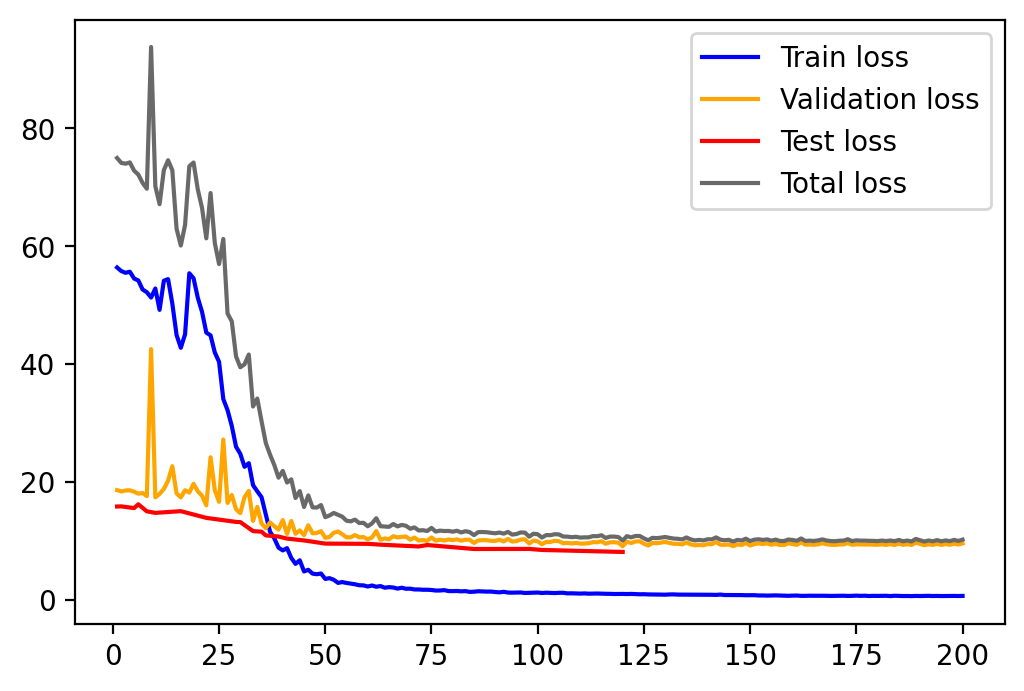

In [6]:
print("Train Loss: {:.4f} | Valid Loss: {:.4f} | Test Loss on Best Model: {:.4f}".format(besttrloss, bestvalloss, besttsloss))
plt.plot(ep,trainloss,color='blue', label = 'Train loss')
plt.plot(ep, validloss, color = 'orange',label = 'Validation loss')
plt.plot(testep, testloss, color = 'red',label = 'Test loss')
plt.plot(ep, totloss, color = 'dimgray',label = 'Total loss')
plt.legend()
plt.show()

In [7]:
tsloss = 0
with torch.no_grad():
    for batch_idx, (data, targets, _) in enumerate(test_loader):
        data = Variable(data).to(device)
        targets = Variable(targets.view(targets.shape[0],-1)).to(device)

        
        scores = best_model(data)
        loss = criterion(scores, targets)

        if batch_idx == 0:
            true_scores = targets.cpu().numpy()
            pred_scores = scores.cpu().numpy()
        else:
            true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)
            pred_scores = np.append(pred_scores, scores.cpu().numpy(), axis = 0)


        tsloss += loss.item()


/home/vip/.local/lib/python3.8/site-packages/torch/nn/modules/rnn.py:661: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:915.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


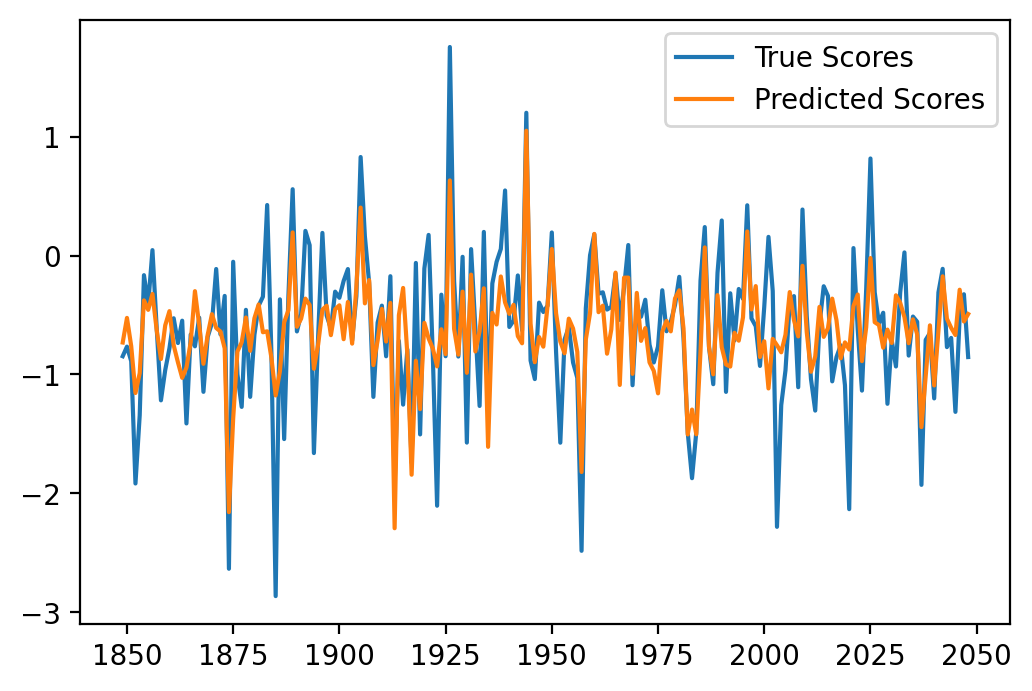

In [11]:
idx = np.array([i+1 for i in range(len(true_scores))])
size = 200
r = np.random.randint(len(idx)-size)
plt.plot(idx[r:r+size], true_scores[r:r+size], label = "True Scores")
plt.plot(idx[r:r+size], pred_scores[r:r+size],label = "Predicted Scores")
plt.legend()
plt.show()

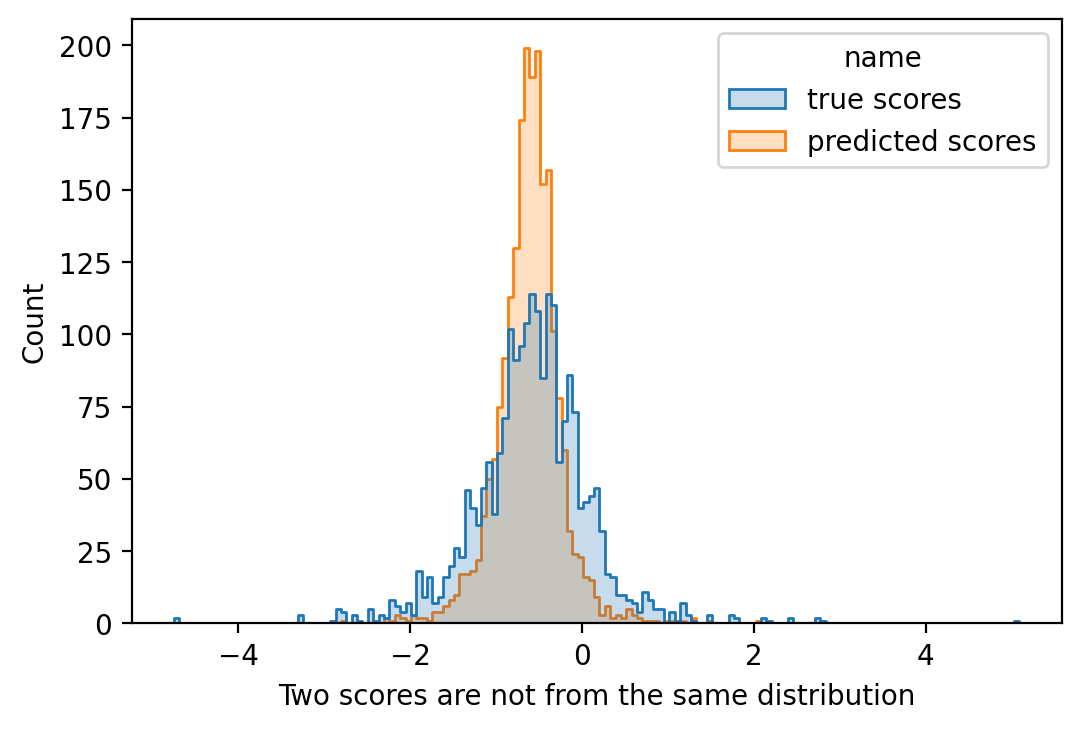

In [12]:
from scipy.stats import ks_2samp
dfx = pd.DataFrame.from_dict({'value': true_scores.ravel().tolist(), 'name':'true scores'})
dfy = pd.DataFrame.from_dict({'value': pred_scores.ravel().tolist(), 'name':'predicted scores'})
df = pd.concat(axis=0, ignore_index=True, objs=[dfx,dfy])



fig,ax = plt.subplots()
sns.histplot(df,x='value',hue='name',ax=ax, element='step')

if ks_2samp(true_scores.ravel().tolist(),pred_scores.ravel().tolist())[1]<0.05:
    plt.xlabel('Two scores are not from the same distribution')
else:
    plt.xlabel('Two scores are from the same distribution')

In [32]:
ks_2samp(true_scores.ravel().tolist(),pred_scores.ravel().tolist())[1]<0.05

True